# Convolutional Neural Network

In [7]:
import torch
import matplotlib.pyplot as plt

from cnn import CNN
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

## Data preprocessing

In [8]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [9]:
train_set = datasets.MNIST(
    root="./data", train=True, download=True, transform=preprocess
)
test_set = datasets.MNIST(
    root="./data", train=False, download=True, transform=preprocess
)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

## Training

In [10]:
model = CNN(
    [
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Flatten(),
        nn.Linear(64 * 14 * 14, 128),
        nn.ReLU(),
        nn.Linear(128, 10),
        nn.Softmax(dim=1),
    ]
)

model.summary(train_loader.dataset[0][0].shape, train_loader.batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 28, 28]             320
              ReLU-2           [64, 32, 28, 28]               0
            Conv2d-3           [64, 64, 28, 28]          18,496
              ReLU-4           [64, 64, 28, 28]               0
         MaxPool2d-5           [64, 64, 14, 14]               0
           Flatten-6                [64, 12544]               0
            Linear-7                  [64, 128]       1,605,760
              ReLU-8                  [64, 128]               0
            Linear-9                   [64, 10]           1,290
          Softmax-10                   [64, 10]               0
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 85.88
Params size (MB): 6.20
Estima

In [11]:
model.config(nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=0.001))

In [12]:
history = model.fit(train_loader, epochs=10)

Epoch 1/10: 100%|██████████| 782/782 [00:05<00:00, 137.83it/s]


Loss: 1.6583, Val Loss: 1.4880, Val Accuracy: 97.40%


Epoch 2/10: 100%|██████████| 782/782 [00:05<00:00, 140.73it/s]


Loss: 1.4849, Val Loss: 1.4832, Val Accuracy: 97.85%


Epoch 3/10: 100%|██████████| 782/782 [00:05<00:00, 132.55it/s]


Loss: 1.4787, Val Loss: 1.4797, Val Accuracy: 98.15%


Epoch 4/10: 100%|██████████| 782/782 [00:05<00:00, 142.57it/s]


Loss: 1.4766, Val Loss: 1.4770, Val Accuracy: 98.45%


Epoch 5/10: 100%|██████████| 782/782 [00:05<00:00, 135.03it/s]


Loss: 1.4744, Val Loss: 1.4749, Val Accuracy: 98.62%


Epoch 6/10: 100%|██████████| 782/782 [00:05<00:00, 142.32it/s]


Loss: 1.4734, Val Loss: 1.4752, Val Accuracy: 98.59%


Epoch 7/10: 100%|██████████| 782/782 [00:05<00:00, 148.41it/s]


Loss: 1.4723, Val Loss: 1.4731, Val Accuracy: 98.84%


Epoch 8/10: 100%|██████████| 782/782 [00:05<00:00, 139.67it/s]


Loss: 1.4717, Val Loss: 1.4701, Val Accuracy: 99.11%


Epoch 9/10: 100%|██████████| 782/782 [00:05<00:00, 134.47it/s]


Loss: 1.4712, Val Loss: 1.4710, Val Accuracy: 99.03%


Epoch 10/10: 100%|██████████| 782/782 [00:05<00:00, 138.27it/s]


Loss: 1.4702, Val Loss: 1.4725, Val Accuracy: 98.90%


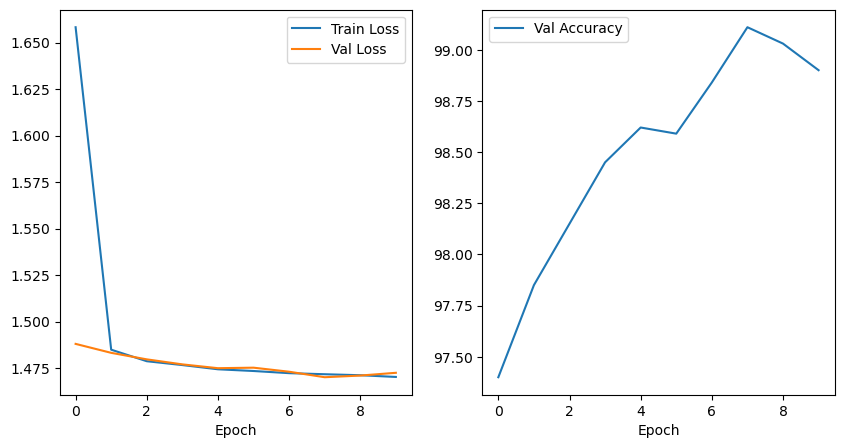

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in history], label="Train Loss")
plt.plot([x[1] for x in history], label="Val Loss")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x[2] for x in history], label="Val Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Test model

In [14]:
x = [images for images, _ in test_loader]
y_true = [labels for _, labels in test_loader]
y_pred = model.predict(test_loader)

In [20]:
total = 0
correct = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for true, pred in zip(y_true, y_pred):
    true, pred = true.to(device), pred.to(device)
    total += len(true)
    correct += (true == pred).sum().item()

accuracy = 100 * (correct / total)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.58%


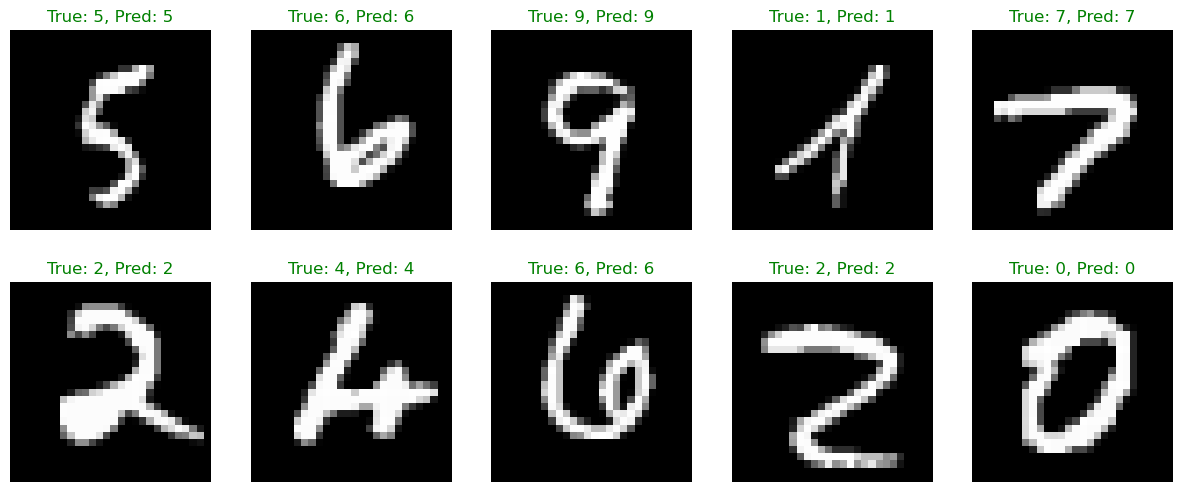

In [41]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    random_idx = torch.randint(0, 64, (1, 2)).squeeze()
    axs[i // 5, i % 5].imshow(x[random_idx[0]][random_idx[1]].squeeze(), cmap="gray")
    color = "green" if y_true[random_idx[0]][random_idx[1]] == y_pred[random_idx[0]][random_idx[1]] else "red"
    axs[i // 5, i % 5].set_title(
        f"True: {y_true[random_idx[0]][random_idx[1]]}, Pred: {y_pred[random_idx[0]][random_idx[1]]}",
        color=color,
    )
    axs[i // 5, i % 5].axis("off")

plt.show()

In [16]:
torch.save(model.state_dict(), "mnist_cnn.pth")